# Kolmogorov-Arnold Network with Legendre approximation
We demonstrate a Kolmogorov-Arnold network whose learned activation functions are Legendre polynomials composed onto
rational normalization. This shows that KAN activations can be approximated in many different ways, and do not have
to be necessarily splines.

In [11]:
import torch
from torch import nn
import torchcurves as tc
import matplotlib.pyplot as plt

## Define regression function

In [12]:
def func(xs):
    pole_1 = torch.tensor(0-2j)
    pole_2 = torch.tensor(0-1j)
    cresult = 10 / (xs[:, 0] + 2 * xs[:, 1] - pole_1) - 2 / (2 * xs[:, 0] - xs[:, 1] - pole_2)
    return cresult.abs()

In [13]:
n = 100
xs = torch.linspace(-3, 3, n)
ys = torch.linspace(-3, 3, n)
grid = torch.cartesian_prod(xs, ys)
zs = func(grid)

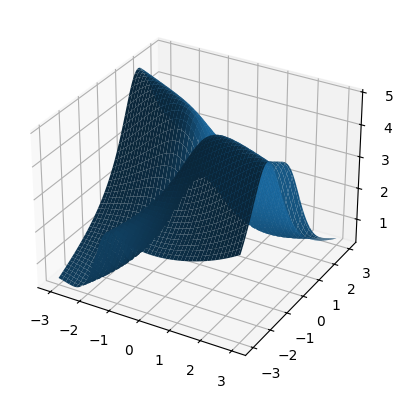

In [14]:
ax = plt.figure().add_subplot(projection='3d')
grid_x = grid[:, 0].reshape(n, n)
grid_y = grid[:, 1].reshape(n, n)
plot_z = zs.reshape(n, n)
ax.plot_surface(grid_x, grid_y, plot_z)

## Generate training data

In [15]:
n_samples = 1000
sigma = 0.3
X = torch.randn(n_samples, 2)
y = func(X) + sigma * torch.randn(n_samples)

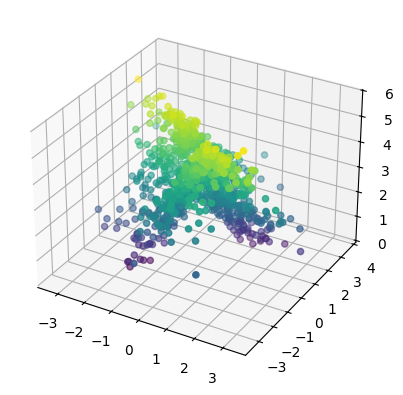

In [16]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], y, c=y)

## Define and train the KAN

In [17]:
input_dim = 2
intermediate_dim = 5
degree = 5

kan = nn.Sequential(
    # layer 1
    tc.LegendreCurve(input_dim, intermediate_dim, degree=degree, normalize_fn='rational'),
    tc.Sum(dim=-2),
    # layer 2
    tc.LegendreCurve(intermediate_dim, intermediate_dim, degree=degree, normalize_fn='rational'),
    tc.Sum(dim=-2),
    # layer 3
    tc.LegendreCurve(intermediate_dim, 1, degree=degree, normalize_fn='rational'),
    tc.Sum(dim=-2),
)

In [18]:
example_data = torch.tensor([[-5, 3], [3, 2], [1, 3]])
output = kan(example_data)
print(output.shape)

torch.Size([3, 1])


In [19]:
n_epochs = 100
batch_size = 32
lr = 2e-3
print_every = 10

dl = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X, y), batch_size=batch_size, shuffle=True)
optim = torch.optim.Adam(kan.parameters(), lr=lr)
criterion = nn.MSELoss()

for epoch in range(1, 1 + n_epochs):
    epoch_loss = 0.
    for Xb, yb in dl:
        pred = kan(Xb)
        cost = criterion(pred.squeeze(), yb)

        optim.zero_grad()
        cost.backward()
        optim.step()

        epoch_loss += cost * Xb.shape[0]

    epoch_loss /= n_samples
    eval_loss = criterion(kan(grid).squeeze(), func(grid))

    if epoch == n_epochs or epoch % print_every == 0:
        print(f'Epoch {epoch}: train loss = {epoch_loss:.3f}, eval_loss = {eval_loss:.3f}')

Epoch 10: train loss = 0.280, eval_loss = 0.436
Epoch 20: train loss = 0.155, eval_loss = 0.195
Epoch 30: train loss = 0.122, eval_loss = 0.157
Epoch 40: train loss = 0.113, eval_loss = 0.141
Epoch 50: train loss = 0.106, eval_loss = 0.136
Epoch 60: train loss = 0.102, eval_loss = 0.117
Epoch 70: train loss = 0.100, eval_loss = 0.111
Epoch 80: train loss = 0.097, eval_loss = 0.108
Epoch 90: train loss = 0.095, eval_loss = 0.107
Epoch 100: train loss = 0.092, eval_loss = 0.103


## Plot the network and the true function, side by side

In [20]:
with torch.no_grad():
    kan_z = kan(grid).reshape(n, n)

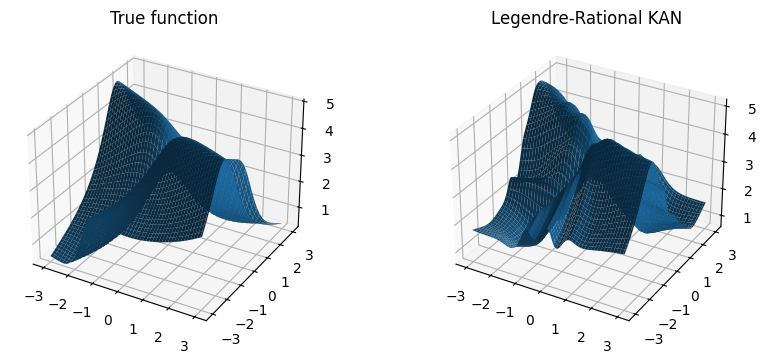

In [21]:
fig = plt.figure(figsize=(10, 4))
ax_left = fig.add_subplot(1, 2, 1, projection='3d')
ax_right = fig.add_subplot(1, 2, 2, projection='3d')

ax_left.set_title('True function')
ax_left.plot_surface(grid_x, grid_y, plot_z)

ax_right.set_title('Legendre-Rational KAN')
ax_right.plot_surface(grid_x, grid_y, kan_z)

plt.show()